#  Potato Disease Classification using Convolutional Neural Network (CNN)

###  Project Overview
This project focuses on detecting and classifying potato plant diseases using Convolutional Neural Networks (CNNs).  
The model is trained on a dataset of potato leaf images, categorized into healthy and diseased classes.  

**Objective:**  
To develop a deep learning model that can automatically identify whether a potato leaf is healthy or affected by a specific disease such as *Early Blight* or *Late Blight*.

**Technologies Used:**
- Python  
- TensorFlow / Keras  
- NumPy & Pandas  
- Matplotlib & Seaborn


## Importing Required Libraries and Dataset

We start by importing the necessary Python libraries for data handling, visualization, and deep learning model building.  
Then we load the dataset, which contains labeled images of potato leaves categorized by disease type.


In [1]:
from tensorflow.keras import models, layers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS= 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("PlantVillage", 
                                                   shuffle=True,
                                                    image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                    batch_size=BATCH_SIZE
                                                   )

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [7]:
for image_batch, label_batch in dataset.take(1):
    # print(image_batch[0])#for 1st image in tecsorabs
    print(image_batch[0].numpy())

[[[179. 173. 175.]
  [177. 171. 173.]
  [179. 173. 175.]
  ...
  [206. 202. 203.]
  [208. 204. 205.]
  [213. 209. 210.]]

 [[194. 188. 190.]
  [191. 185. 187.]
  [191. 185. 187.]
  ...
  [203. 199. 200.]
  [202. 198. 199.]
  [204. 200. 201.]]

 [[192. 186. 188.]
  [191. 185. 187.]
  [191. 185. 187.]
  ...
  [208. 204. 205.]
  [204. 200. 201.]
  [204. 200. 201.]]

 ...

 [[127. 117. 116.]
  [131. 121. 120.]
  [135. 125. 124.]
  ...
  [146. 137. 140.]
  [147. 138. 141.]
  [140. 131. 134.]]

 [[131. 121. 120.]
  [132. 122. 121.]
  [134. 124. 123.]
  ...
  [145. 136. 139.]
  [143. 134. 137.]
  [142. 133. 136.]]

 [[140. 130. 129.]
  [137. 127. 126.]
  [135. 125. 124.]
  ...
  [141. 132. 135.]
  [138. 129. 132.]
  [146. 137. 140.]]]


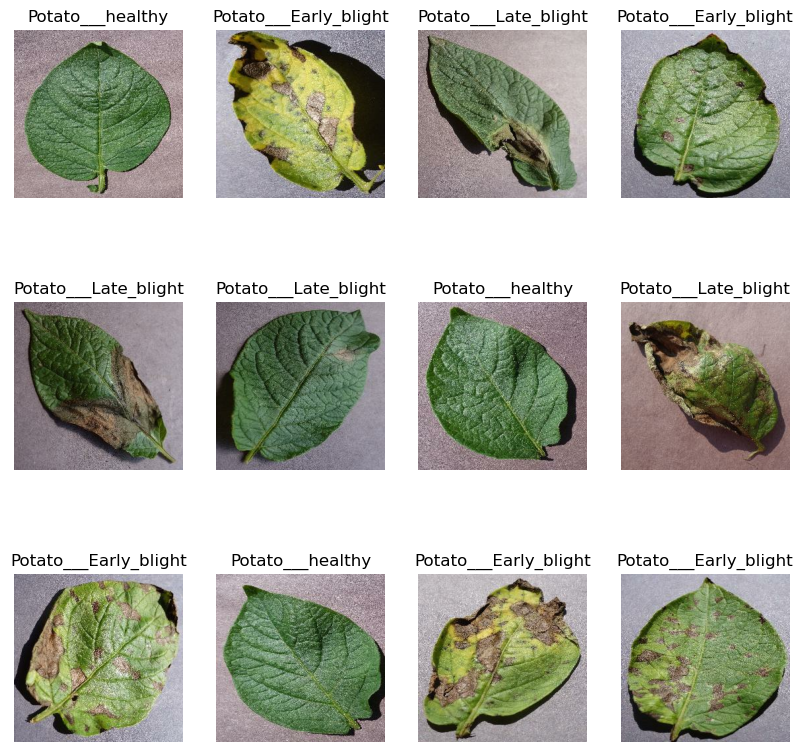

In [9]:
plt.figure(figsize=(10, 10))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))   # use i, not 0
        plt.title(class_names[label_batch[i].numpy()])       # fixed bracket + .numpy()
        plt.axis("off")


##  Data Splitting, Preprocessing, and Augmentation

Before training the model, the dataset is divided into three parts to ensure proper training and evaluation:

- **80% → Training Set:** Used for learning model parameters.  
- **20% → Validation Set:** Used to tune hyperparameters and avoid overfitting.  
- **10% → Test Set:** Used for final model evaluation on unseen data.

After splitting, all images are resized, normalized, and augmented using transformations such as rotation, flipping, and zooming.  
These preprocessing steps ensure consistency in image dimensions and improve model generalization.


In [11]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [12]:
train_ds= dataset.take(54)
len(train_ds)

54

In [13]:
test_ds =dataset.skip(54)
len(train_ds)

54

In [14]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    shuffle=True

    if shuffle:   # now matches argument
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds


In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

54

In [20]:
len(val_ds)

6

In [21]:
len(test_ds)

8

In [22]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])


In [24]:
 data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])


##  Building the Convolutional Neural Network (CNN)

A Convolutional Neural Network (CNN) is designed to extract image features and classify them into healthy or diseased categories.  
The model architecture consists of multiple convolutional, pooling, and fully connected layers for effective feature learning.


In [25]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS = 3
n_classes = 3

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

The CNN model is trained on the preprocessed dataset using an appropriate optimizer (e.g., Adam) and loss function (e.g., categorical crossentropy).  
During training, accuracy and loss metrics are tracked to evaluate performance over multiple epochs.


In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
EPOCHS = 50   

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    verbose=1,
    validation_data=val_ds
)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.4925 - loss: 0.8998 - val_accuracy: 0.7031 - val_loss: 0.8614
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.7153 - loss: 0.6578 - val_accuracy: 0.8281 - val_loss: 0.4721
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.8247 - loss: 0.4199 - val_accuracy: 0.8698 - val_loss: 0.3438
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.8559 - loss: 0.3446 - val_accuracy: 0.8177 - val_loss: 0.3900
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.8657 - loss: 0.3238 - val_accuracy: 0.9010 - val_loss: 0.2874
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.8895 - loss: 0.2772 - val_accuracy: 0.8698 - val_loss: 0.4263
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.8970 - loss: 0.2614 - val_accuracy: 0.9167 - val_loss: 0.2088
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.8843 - loss: 0.2719 - val_accuracy: 0.9219 - v

In [28]:
scores = model.evaluate(test_ds )

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 581ms/step - accuracy: 0.9883 - loss: 0.0366


In [29]:
scores

[0.036612849682569504, 0.98828125]

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [31]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [32]:
len( history.history['accuracy'])

50

##  Model Evaluation and Performance Analysis

After training, the model’s performance is assessed using validation data.  
Metrics such as accuracy, loss, and confusion matrix help analyze how well the model distinguishes between healthy and diseased leaves.


In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

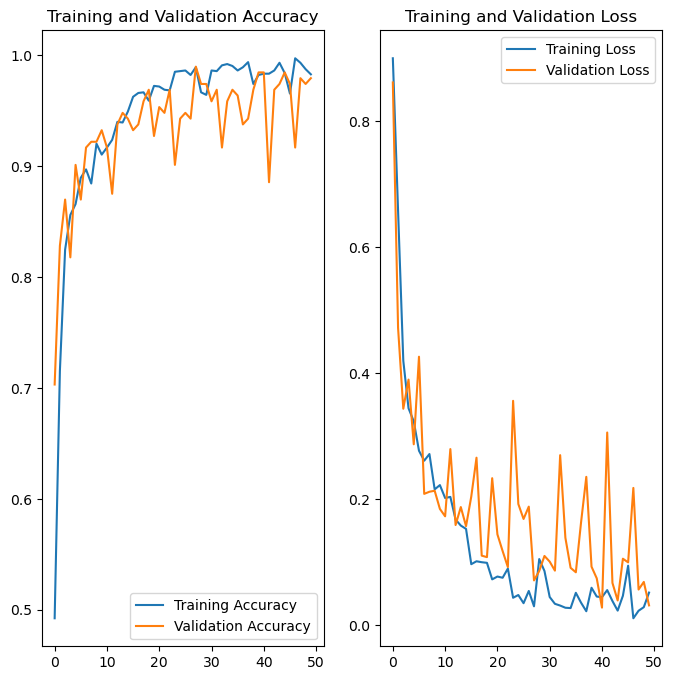

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy' )
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy' )

plt.subplot(1, 2, 2)
plt.plot (range(EPOCHS), loss, label='Training Loss')
plt.plot (range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
# np.argmax([9.9999964e-1])
np.argmax([9.9999964e-01,3.9333537e-07,1.1586251e-18])

np.int64(0)

## Testing on New Images

In this step, the trained model is tested on unseen potato leaf images to check how accurately it predicts disease types.  
This demonstrates the model’s real-world applicability.
Using two ways first for the single test other one is multiple test.


first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step
predicted label: Potato___Early_blight


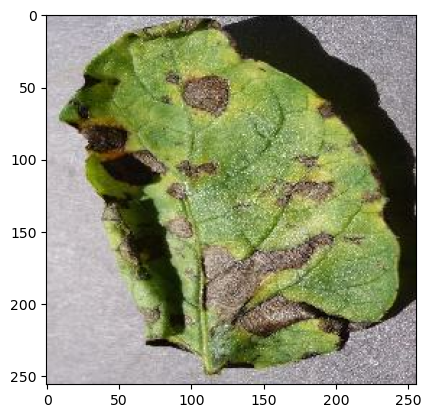

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

   first_image = images_batch[0].numpy().astype('uint8')
   first_label = labels_batch[0].numpy()

   print("first image to predict")
   plt.imshow(first_image)
   print("actual label:",class_names[first_label])

   batch_prediction = model.predict(images_batch)
   print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model, img):
   img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
   img_array = tf.expand_dims(img_array, 0) # Create a batch

   predictions = model.predict(img_array)

   predicted_class = class_names[np.argmax(predictions[0])]
   confidence = round(100 * (np.max(predictions[0])), 2)
   return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


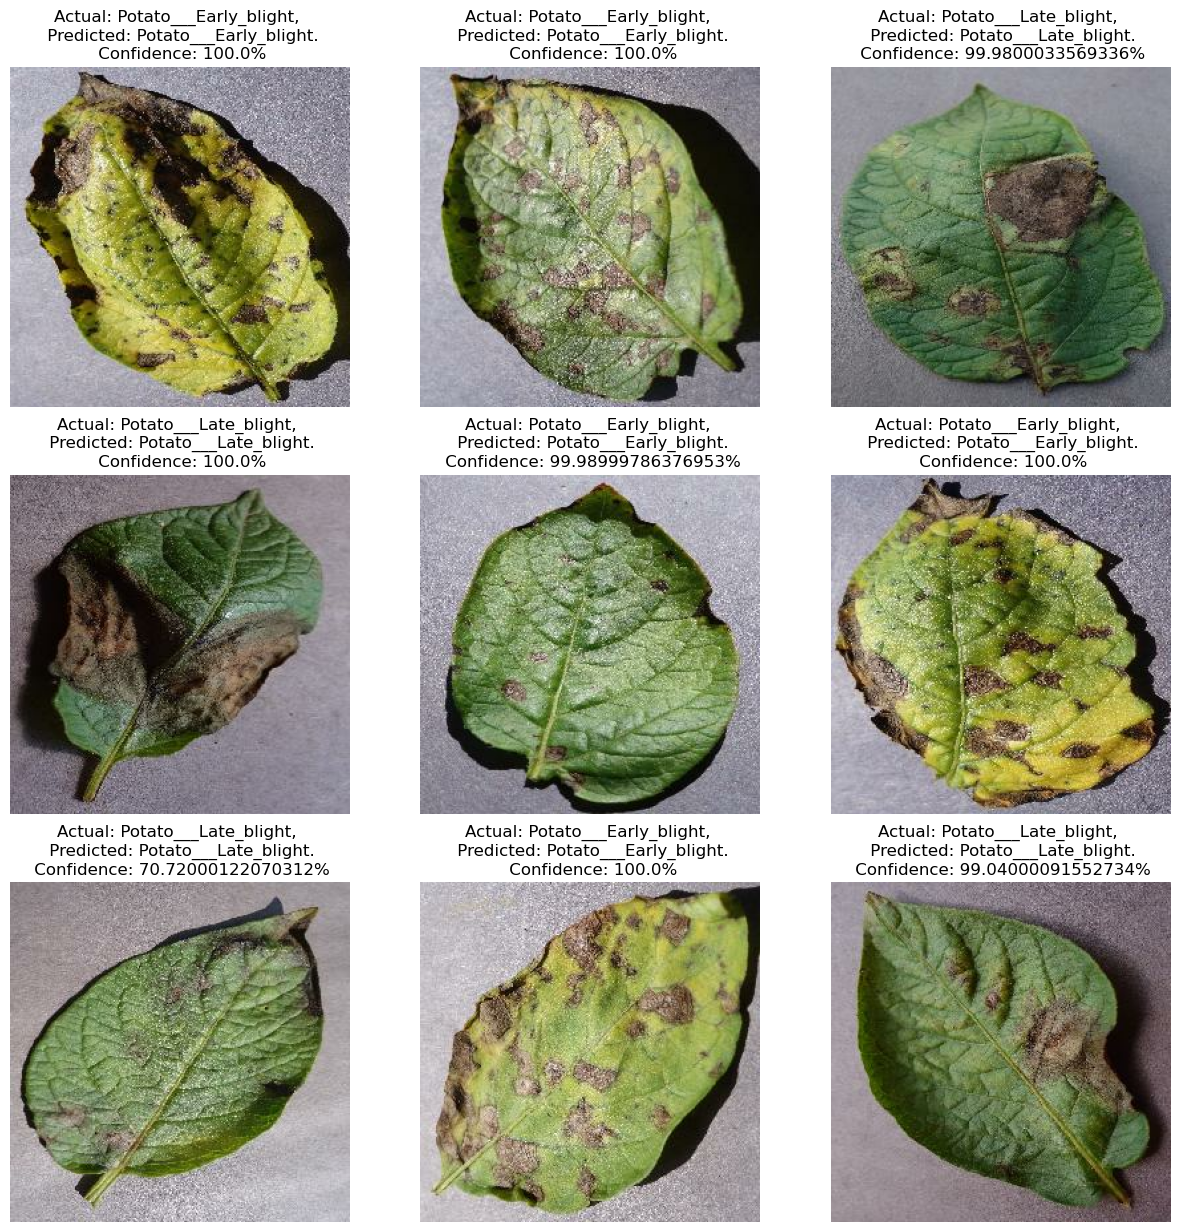

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")

    plt.axis("off")



## Conclusion

The CNN-based potato disease classifier successfully identifies diseased and healthy leaves with good accuracy.  
This model can assist farmers and researchers in early disease detection, leading to better crop management.

**Future Enhancements:**
- Deploy the model using a web or mobile application by exporting or saving the model.  
- Extend the dataset with more plant species.  
- Integrate real-time image capture for live diagnosis.


In [41]:
model_version = 1
model.export(f"../training/models/{model_version}")


INFO:tensorflow:Assets written to: ../training/models/1\assets


INFO:tensorflow:Assets written to: ../training/models/1\assets


Saved artifact at '../training/models/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2092833773840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2092833773456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2092834184976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2092834186128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2092834185936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2092834186320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2092834184400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2092834186704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2092834186512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2092834187088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2092834187664: TensorSpec(shap

In [44]:
# Save
model.save("../training/models/1.keras")